In [ ]:
import torch
import numpy as np
from torch import nn 
import random
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
imiona = open("imionapl.txt", encoding = "UTF-8").read().splitlines()
imiona = [i.lower() for i in imiona]
imiona[:5]

['ada', 'adalbert', 'adam', 'adela', 'adelajda']

In [ ]:
chars = sorted(list(set(''.join(imiona))))
stoi = {s:i +1  for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i :s for s, i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)

31


In [ ]:
block_size = 3 
def build_dataset(imiona):  
    X, Y = [], []
    for w in imiona:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
random.seed(42)
random.shuffle(imiona)
n1 = int(0.8*len(imiona))
n2 = int(0.9*len(imiona))

X_train, Y_train = build_dataset(imiona[:n1])
X_dev, Y_dev = build_dataset(imiona[n1:n2])
X_test, Y_test = build_dataset(imiona[n2:])
    

torch.Size([3919, 3]) torch.Size([3919])
torch.Size([510, 3]) torch.Size([510])
torch.Size([480, 3]) torch.Size([480])


In [ ]:
dims = 10 
hidden_neurons = 200

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, dims))
W1_3 = torch.randn((dims*block_size, hidden_neurons), generator = g) * (5/3)/((dims*block_size)**0.5) #5/3 is a fixed value for tanh activation known as "gain"
b1_3 = torch.randn((hidden_neurons), generator = g) * 0 
W2_3 = torch.randn((hidden_neurons, vocab_size), generator = g)* (5/3)/((hidden_neurons)**0.5)
b2_3 = torch.randn((vocab_size), generator = g) * 0 

# gain and bias initialization
batch_gain = torch.ones((1, hidden_neurons))
batch_bias = torch.zeros((1, hidden_neurons))


batch_mean_running = torch.ones((1, hidden_neurons))
batch_std_running = torch.zeros((1, hidden_neurons))


parameters_3 = [C, W1_3, W2_3, b1_3,b2_3, batch_gain, batch_bias]
def enable_grad(parameters):
    for p in parameters:
        p.requires_grad = True
enable_grad(parameters_3)

In [ ]:
batch_bias

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True)

In [ ]:
def model(X_train,Y_train, batch_size, parameters, max_steps, batch_mean_running, batch_std_running):
    losses, accuracies = [],[]
    C, W1, W2, b1,b2, batch_gain, batch_bias = parameters
    for i in range(max_steps):

        ix = torch.randint(0, X_train.shape[0], (32,))
        X_batched, Y_batched = X_train[ix], Y_train[ix]
        # forward pass
        emb = C[X_batched]
        #print(f"""emb :{emb.shape}""")
        embcat = emb.view(emb.shape[0], -1)
        # Linear layer
        h_preact = embcat @ W1 + b1
        batch_mean_i = h_preact.mean(0, keepdims = True)
        batch_std_i =  h_preact.std(0, keepdims = True)
        h_preact = batch_gain * ( h_preact - batch_mean_i) /batch_std_i + batch_bias
        #done on the side of gradient based optimization
        with torch.no_grad():
            batch_mean_running = batch_mean_running * 0.999 + 0.001 * batch_mean_i
            batch_std_running = batch_std_running * 0.999 + 0.001 * batch_std_i
        h = torch.tanh(h_preact)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y_batched)
        cat = torch.argmax(logits, dim=1)
        accuracy = (cat == Y_batched).float().mean()
        if i % 100 == 0:
            print(f"""loss :{loss.item()}, accuracy :{accuracy.item()}""")
        losses.append(loss.item())
        accuracies.append(accuracy.item())
        #backward
        for p in parameters:
            p.grad = None
        loss.backward()


        for p in parameters:
            p.data += -0.15 * p.grad

    plt.plot(np.arange(max_steps), losses);
    plt.plot(np.arange(max_steps), accuracies);

loss :3.7552874088287354, accuracy :0.0625
loss :2.4642889499664307, accuracy :0.15625
loss :2.352231979370117, accuracy :0.3125
loss :2.0257818698883057, accuracy :0.5
loss :2.437164783477783, accuracy :0.21875
loss :1.9883171319961548, accuracy :0.34375
loss :2.6806464195251465, accuracy :0.1875
loss :2.6077919006347656, accuracy :0.28125
loss :2.2507331371307373, accuracy :0.3125
loss :2.1161465644836426, accuracy :0.375


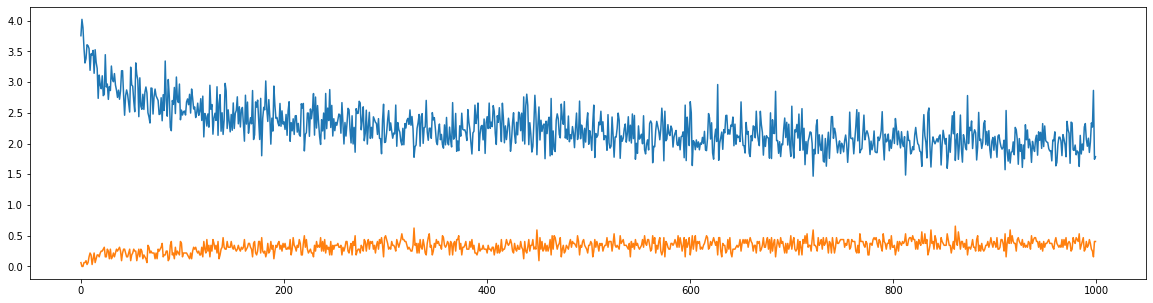

In [ ]:
plt.figure(figsize = (20,5))
model(X_train,Y_train, 32, parameters_3, 1000, batch_mean_running, batch_std_running)

In [ ]:

with torch.no_grad():
    def split_loss(split_x, split_y, parameters):
        C, W1, W2, b1,b2, batch_gain, batch_bias = parameters
        emb = C[split_x] # (N, block_size, n_embd)
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        h_preact = embcat @ W1  + b1
        h_preact = batch_gain * ( h_preact - h_preact.mean(0, keepdims = True)) / h_preact.std(0, keepdims = True) + batch_bias
        h = torch.tanh(h_preact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        loss = F.cross_entropy(logits, split_y)
        print(f"""loss :{loss.item()}""")

print("losses for parameters")
split_loss(X_train, Y_train, parameters_3)
split_loss(X_test, Y_test, parameters_3)

losses for parameters
loss :1.9502055644989014
loss :2.2508761882781982


In [ ]:

with torch.no_grad():
    emb = C[X_train]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1_3 # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [ ]:
bnmean

tensor([[-7.6845e-01, -1.9134e-02,  1.3547e-01, -1.3342e-01,  3.2354e-01,
          3.4567e-01, -1.7907e-01,  8.9069e-01, -6.8655e-02,  7.0201e-01,
         -4.8329e-01,  2.5952e-01, -1.0620e-01, -1.7462e-01,  8.7802e-01,
          4.9062e-01, -3.8292e-02,  9.5800e-02,  2.6473e-01,  4.1556e-01,
         -2.3347e-01,  1.0073e+00,  2.1542e-01,  4.6549e-01, -4.2079e-01,
          3.2472e-01, -2.1026e-01, -4.7239e-01,  3.7049e-01, -3.3011e-01,
         -3.8042e-01,  8.0501e-02, -2.3499e-01,  2.0412e-01,  4.5997e-01,
         -3.9406e-01, -1.6991e-01,  4.9040e-01,  9.3415e-01, -3.6409e-01,
         -3.4091e-01,  3.8420e-01,  1.9830e-01, -4.7285e-02,  9.9039e-01,
         -8.9838e-01,  7.9663e-01,  6.0862e-01,  1.8674e-01,  6.7140e-02,
          4.4224e-01,  4.1321e-02, -2.0930e-01,  5.1943e-01,  3.3223e-01,
          4.9228e-02, -1.3734e-01,  2.7281e-01,  2.6539e-01,  7.6961e-01,
         -3.9866e-01,  3.0226e-01,  6.8759e-01,  2.4114e-01, -4.0626e-02,
          5.2084e-01, -1.7476e-01, -9.